# <font color = 'red'> Interact with Google Colab

In [0]:
# !ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
# !pip install gputil -q
# !pip install psutil -q
# !pip install humanize -q
# import psutil
# import humanize
# import os
# import GPUtil as GPU
# GPUs = GPU.getGPUs()
# # XXX: only one GPU on Colab and isn’t guaranteed
# gpu = GPUs[0]
# def printm():
#  process = psutil.Process(os.getpid())
#  print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
#  print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
# printm()

In [1]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.

# PyDrive simplifies many common Google Drive API tasks.
!pip install -U -q PyDrive
# -q means quiet

# provide the ability to authenticate to Google APIs using various methods.
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


    100% |████████████████████████████████| 993kB 10.1MB/s 


In [2]:

# Be able to work within google folder
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
# tells you how much data you have on their servers. look at /dev/sda1
!df -BG

Filesystem     1G-blocks  Used Available Use% Mounted on
overlay             359G   22G      319G   7% /
tmpfs                 7G    0G        7G   0% /dev
tmpfs                 7G    0G        7G   0% /sys/fs/cgroup
tmpfs                 7G    1G        7G   1% /var/colab
/dev/sda1           365G   26G      340G   7% /opt/bin
shm                   6G    0G        6G   0% /dev/shm
tmpfs                 7G    0G        7G   0% /sys/firmware
drive               100G   44G       57G  44% /content/drive


In [4]:
!pwd

/content


In [5]:
# Change directory to the one this notebook is in
import os
os.chdir("drive/My Drive/Colab Notebooks/")
!ls

audio_df2.pkl  audio_df.pkl	       model.json	 train_audio
audio_df3.pkl  AudioRecognition.ipynb  model_weights.h5  vox1_meta.csv
audio_df4.pkl  full_df.pkl	       test_audio


In [6]:
!pwd

/content/drive/My Drive/Colab Notebooks


# <font color = 'red' >Prep data

data came from: 
http://www.robots.ox.ac.uk/~vgg/data/voxceleb/vox1.html

In [0]:
# unzip the test set
!unzip vox1_test_aac.zip

In [0]:
# concat the 4 parts of training set
cat vox1_dev_wav_* > vox1_dev_wav.zip

In [0]:
# unzip the concat file
!unzip vox1_dev_wav.zip

In [8]:
# import necessary libraries
import re
import wave 
import itertools
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
from matplotlib import pyplot as plt
import seaborn as sns
import librosa
import librosa.feature 
import librosa.display
# import talos as ta
# from talos import live
# from talos.model import hidden_layers
from keras import layers, optimizers
from keras.models import model_from_json
from keras.models import Sequential, Model
from keras.optimizers import Adam, sgd, Adamax
from keras.callbacks import EarlyStopping
from keras.layers.advanced_activations import LeakyReLU, PReLU
from keras.layers import Dense, LSTM, Dropout, Flatten, Input, Conv1D, MaxPooling1D
from keras.activations import relu, elu, softmax, selu
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc


Using TensorFlow backend.


## get labels into dataframe

In [9]:
# read the meta csv file
meta_df = pd.read_csv('vox1_meta.csv', delimiter = '\t' )
meta_df.head()

,VoxCeleb1 ID,VGGFace1 ID,Gender,Nationality,Set
0,id10001,A.J._Buckley,m,Ireland,dev
1,id10002,A.R._Rahman,m,India,dev
2,id10003,Aamir_Khan,m,India,dev
3,id10004,Aaron_Tveit,m,USA,dev
4,id10005,Aaron_Yoo,m,USA,dev


In [14]:
# change the column names to be more intuitive and lowercased
meta_df.columns = ['id', 'name', 'gender', 'nationality', 'set'] # rename columns
meta_df.head() # shape of df: (1251, 5)

,id,name,gender,nationality,set
0,id10001,A.J._Buckley,m,Ireland,dev
1,id10002,A.R._Rahman,m,India,dev
2,id10003,Aamir_Khan,m,India,dev
3,id10004,Aaron_Tveit,m,USA,dev
4,id10005,Aaron_Yoo,m,USA,dev


## get training data


- **mfcc**: Mel-frequency cepstral coefficients
- **melspectrogram**: Compute a Mel-scaled power spectrogram
- **chorma-stft**: Compute a chromagram from a waveform or power spectrogram
    - in music, the term chroma feature or chromagram closely relates to the twelve different pitch classes. Chroma-based features, which are also referred to as "pitch class profiles", are a powerful tool for analyzing music whose pitches can be meaningfully categorized and whose tuning approximates to the equal-tempered scale. 
- **spectral_contrast**: Compute spectral contrast
    - Spectral contrast is defined as the level difference between peaks and valleys in the spectrum
- **tonnetz**: Computes the tonal centroid features (tonnetz), following the method of [2]

In [0]:
def extract_feat(filename, filepath):
  
  # load in audio file
  y, sr = librosa.load(filepath + filename) # y = audio file, sr = sample rate

  # extract the various features of the audio
  mfcc = np.mean(librosa.feature.mfcc(y = y, sr = sr, n_mfcc=40).T, axis = 0)  
  mel = np.mean(librosa.feature.melspectrogram(y = y, sr = sr).T, axis = 0)
  stft = np.abs(librosa.stft(y))
  chroma = np.mean(librosa.feature.chroma_stft(S = stft, y = y, sr = sr).T, axis = 0)
  contrast = np.mean(librosa.feature.spectral_contrast(S = stft, y = y, sr = sr).T, axis = 0)
  tonnetz =  np.mean(librosa.feature.tonnetz(y = librosa.effects.harmonic(y), sr = sr).T, axis = 0)
  
  return mfcc,chroma,mel,contrast,tonnetz # shape: (40,), (12,), (128,), (7,), (6,)
  

In [0]:
# Instatiate a dataframe the train audio features will be in 
columns = ['id'] + ['mfcc']*40 + ['chroma']*12 + ['mel']*128 + ['contrast']*7 + ['tonnetz']*6
audio_df = pd.DataFrame(columns = columns)
audio_df # 0 rows × 194 columns

,id,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,...,contrast,contrast,contrast,contrast,tonnetz,tonnetz,tonnetz,tonnetz,tonnetz,tonnetz


In [0]:
# Get data, extract features, append features into dataframe
ids = [f for f in listdir('train_audio/')] # get the filenames (ids) in the train_audio/ directory
for idd in ids[344:]:
  subfiles = [f for f in listdir('train_audio/{}'.format(idd))] # go into each celeb file
  
  for subfile in subfiles:
    audiofiles = [f for f in listdir('train_audio/{}/{}'.format(idd, subfile))] # extract the audio files in each subfile
    
    for audiofile in audiofiles:
      pathname = 'train_audio/{}/{}/'.format(idd, subfile)
      mfcc,chroma,mel,contrast,tonnetz = extract_feat(audiofile, pathname)
      features = np.hstack([mfcc,chroma,mel,contrast,tonnetz])
     
      # get the id in integer form
      idd_int = int(idd[2:])

      # add id in the front of the features array
      labelled = np.insert(features, 0, idd_int, axis = 0)
      fill = np.empty((0,194))
      row = np.vstack([fill,labelled]) # shape (1,193)
      
      # put row in a dataframe
      row_df = pd.DataFrame(row, columns = columns)

      # append row_df into the dataframe
      audio_df = audio_df.append(row_df, ignore_index = True)



<font color = 'blue'> **because it takes hours to collect ~100 ids, had to collect in iteration. Saved these iterations in audio_df(#).pkl files. There are four pickle files, all together collected ~500 IDs. **

In [0]:
# Save dataframe in a pickle file
audio_df.to_pickle('audio_df4.pkl')

In [0]:
df4 = pd.read_pickle('audio_df4.pkl')
df4.id.unique().shape

(194,)

## Test/Train/Split final dataframe

In [0]:
# Read in all the pickle files and concat/join/merge
df1 = pd.read_pickle('audio_df.pkl')
df2 = pd.read_pickle('audio_df2.pkl')
df3 = pd.read_pickle('audio_df3.pkl')
df4 = pd.read_pickle('audio_df4.pkl')
df = pd.concat([df1,df2,df3,df4])

In [0]:
# Set display options to 200 columns to be able to see all 193 columns
pd.set_option('display.max_columns', 200)

In [17]:
df.shape # (64483, 194)
df.tail()

,id,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,chroma,chroma,chroma,chroma,chroma,chroma,chroma,chroma,chroma,chroma,chroma,chroma,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,mel,contrast,contrast,contrast,contrast,contrast,contrast,contrast,tonnetz,tonnetz,tonnetz,tonnetz,tonnetz,tonnetz
24778,11100.0,-503.800568,159.991782,-16.537968,37.070034,-4.459876,1.584697,-3.264234,6.204571,-6.923838,-0.757389,2.842366,-3.018444,5.399441,2.729970,4.665108,-9.940535,-2.158047,-1.898706,-0.797725,-0.538610,-3.721104,-6.202170,-9.058631,0.302317,-6.527288,-4.754056,-3.112750,0.613957,0.508048,-2.096162,1.506327,1.187206,1.999975,1.129699,6.913423,2.863409,-0.923728,-0.756724,-0.185686,-0.967237,0.497434,0.479296,0.526856,0.480500,0.492818,0.517734,0.575788,0.639266,0.614953,0.520258,0.534425,0.521624,0.000793,0.005434,0.030386,0.006876,0.006212,0.009032,0.059345,0.094872,0.042270,0.020747,0.055137,0.036292,0.003616,0.011298,0.057143,0.090732,0.046198,0.043124,0.039419,0.044442,0.026989,0.021998,0.088756,0.081188,0.095127,0.057110,0.063391,0.052137,0.061667,0.052075,0.037905,0.012853,0.021025,0.008507,0.006129,0.012864,0.035194,0.050898,0.052126,0.017207,0.024111,0.013910,0.011910,0.016019,0.018280,0.013507,0.003757,0.002855,0.003046,0.001857,0.002147,0.002103,0.003201,0.008896,0.005241,0.003217,0.005578,0.004855,0.004800,0.001446,0.000582,0.001034,0.001469,0.000948,0.000737,0.001306,0.002862,0.001120,0.000777,0.000475,0.000245,0.000148,0.000372,0.001103,0.001979,0.001484,0.001756,0.000432,0.000250,0.000339,0.000319,0.000238,0.000163,0.000097,0.000072,0.000047,0.000091,0.000105,0.000041,0.000033,0.000038,0.000029,0.000019,0.000019,0.000017,0.000017,0.000008,0.000005,0.000009,0.000015,0.000020,0.000010,0.000006,0.000007,0.000009,0.000006,0.000008,0.000008,0.000007,7.056818e-06,9.596689e-06,6.661124e-06,5.487163e-06,3.610811e-06,1.066116e-06,3.940568e-08,4.386587e-09,3.934327e-09,3.616842e-09,3.364994e-09,3.155534e-09,2.986337e-09,2.844588e-09,2.727968e-09,2.635663e-09,2.563692e-09,2.513333e-09,2.481457e-09,18.123065,16.864310,20.108288,18.542917,19.385362,19.506113,60.697950,0.007471,0.020963,0.050210,-0.102916,-0.026035,0.005766
24779,11100.0,-442.607326,160.302527,-31.399481,21.130893,-10.974108,4.796752,-5.693317,3.232060,0.999348,-0.711150,2.550994,-4.104016,3.072689,3.371486,3.884172,-9.338989,-4.311083,-2.956424,-4.952378,-3.204237,-1.798397,-3.337122,-2.487623,3.405535,-3.631716,-1.138690,-3.985064,0.040738,4.584732,-1.081874,-0.537442,0.576348,0.446506,-1.680391,-0.161449,-2.273001,-3.235756,-5.072984,-3.912861,-1.930381,0.632974,0.534964,0.563326,0.562226,0.545896,0.483770,0.442797,0.494035,0.542529,0.576757,0.589167,0.653003,0.001122,0.006539,0.036587,0.013001,0.013548,0.013358,0.015413,0.063964,0.060538,0.070826,0.159765,0.199303,0.054368,0.009223,0.063817,0.053219,0.120010,0.245420,0.271008,0.344488,0.079667,0.072464,0.166110,0.132764,0.255801,0.269304,0.199609,0.077808,0.054156,0.045447,0.033343,0.043260,0.080957,0.161356,0.161980,0.165373,0.261900,0.237476,0.177378,0.128297,0.091435,0.041402,0.071076,0.108694,0.132639,0.028384,0.018485,0.010136,0.008793,0.010192,0.014159,0.006357,0.041276,0.035302,0.019856,0.015073,0.012102,0.008323,0.010512,0.018413,0.007697,0.002625,0.002576,0.002031,0.004848,0.004092,0.004719,0.003144,0.001334,0.000752,0.000601,0.000957,0.002569,0.003178,0.002321,0.001084,0.000905,0.000736,0.00070

In [18]:
# Check how many ids were loaded into dataframe...not going to load all of them
df.id.unique().shape # (537,)

(537,)

In [0]:
# Split the dataframe into x and y
y = df.id
x = df.iloc[:,1:]

In [0]:
# Train, test, split into training and testing
x_train1, x_test, y_train1, y_test = train_test_split(x,y, test_size = 0.1, random_state = 121)

In [0]:
# Split the training data into training and validation
x_train, x_val, y_train, y_val = train_test_split(x_train1, y_train1, test_size = 0.2, random_state = 121)

In [22]:
# look at the shape of each portion of data
x_train.shape # (46427, 193)
x_val.shape # (11607, 193)
x_test.shape # (6449, 193)

y_train.shape # (46427,)
y_val.shape # (11607,)
y_test.shape # (6449,) 

(6449,)

In [23]:
# reshape x datasets from 2D into 3D arrays
x_train_array = x_train.values # convert df to array
x_train_ = np.reshape(x_train_array, newshape = (46427, 1,193))
x_train_.shape # (46427, 1, 193)

x_val_array = x_val.values # convert df to array
x_val_ = np.reshape(x_val_array, newshape = (11607, 1,193))
x_val_.shape # (11607, 1,193)

x_test_array = x_test.values # convert df to array
x_test_ = np.reshape(x_test_array, newshape = (6449, 1, 193))
x_test_.shape # (6449, 1, 193)


(6449, 1, 193)

In [24]:
# reshape y data for last layer in models (softmax activation function)
y_train_cat = pd.get_dummies(y_train) # converts variables in one column to have their own column
y_train_ = y_train_cat.values 
y_train_.shape # (46427, 537)

y_val_cat = pd.get_dummies(y_val) # converts variables in one column to have their own column
y_val_ = y_val_cat.values 
y_val_.shape # (11607, 537)

y_test_cat = pd.get_dummies(y_test) # converts variables in one column to have their own column
y_test_ = y_test_cat.values 
y_test_.shape # (6449, 537)


(6449, 537)

# <font color = 'red' >Models

## PReLU Model

In [0]:
# Set seed to get same results
np.random.seed(123)
# Define model as Sequential class
model = Sequential()

In [0]:
model.add(layers.Dense(128, input_shape = (1,193)))
model.add(PReLU(alpha_initializer='zeros'))

model.add(PReLU())
model.add(PReLU())
model.add(Dropout(rate = 0.1))

model.add(layers.Dense(256))
model.add(PReLU())
model.add(PReLU())

model.add(layers.Dense(542))
model.add(PReLU())
model.add(PReLU())
model.add(Dropout(rate = 0.1))

model.add(layers.Dense(542))
model.add(PReLU())
model.add(PReLU())

model.add(layers.Dense(256))
model.add(PReLU())
model.add(PReLU())
model.add(Dropout(rate = 0.1))

model.add(layers.Dense(256))
model.add(PReLU())
model.add(PReLU())

model.add(layers.Dense(128))
model.add(PReLU())
model.add(PReLU())
model.add(Dropout(rate = 0.1))

model.add(layers.Dense(128))
model.add(PReLU())
model.add(PReLU())

model.add(layers.Dense(128))
model.add(PReLU())

model.add(layers.Flatten())
model.add(Dense(537, activation = 'softmax'))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
opt = Adamax(lr = 1e-3, decay = 1e-5)
model.compile(loss = 'categorical_crossentropy', 
              optimizer = opt,
             metrics = ['accuracy'])

In [0]:
earlystop = EarlyStopping(monitor='val_loss',
                              min_delta=0.001,
                              patience=3,
                              verbose=0, mode='auto')

In [0]:
history = model.fit(x_train_, 
                    y_train_, 
                    epochs = 100, 
                    batch_size = 25,
                    validation_data= (x_val_,y_val_), callbacks = [earlystop])


46427/46427 [==============================] - 28s 598us/step - loss: 0.9288 - acc: 0.7560 - val_loss: 1.5074 - val_acc: 0.7010


### Errors & Accuracy Plot

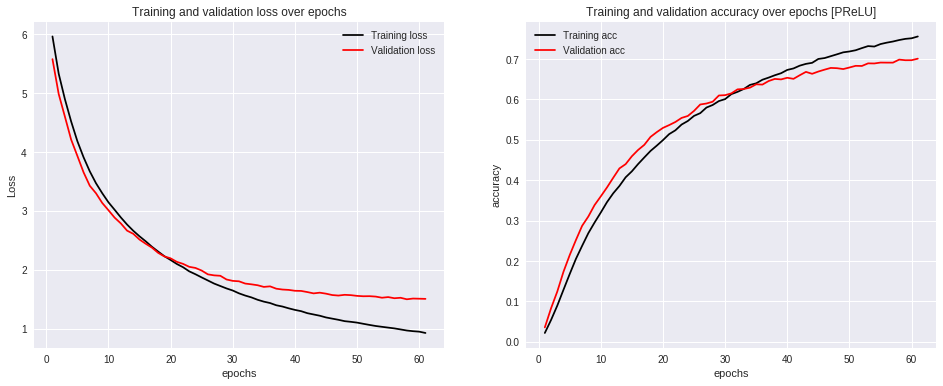

In [0]:
%matplotlib inline
# Look at the history of the model
hist_dense = model.history.history # contains information from fitting model
hist_dense.keys() # returns: dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

# Call each key to get the values to plot
loss_prelu = hist_dense['loss'] 
val_loss_prelu = hist_dense['val_loss']
acc_prelu = hist_dense['acc']
val_acc_prelu = hist_dense['val_acc']

epochs = range(1, len(loss_prelu) + 1)

# Plot Losses of training and validation sets v. epochs
plt.figure(figsize=(25,6))
plt.subplot(131)
plt.plot(epochs, loss_prelu, 'k', label = 'Training loss')
plt.plot(epochs, val_loss_prelu, 'r', label = 'Validation loss')

# Add the good stuff                      
plt.title('Training and validation loss over epochs')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy scores over epochs for training and validation sets                      
plt.subplot(132)
plt.plot(epochs, acc_prelu, 'k', label='Training acc')
plt.plot(epochs, val_acc_prelu, 'r', label= 'Validation acc')

# Add the good stuff                      
plt.title('Training and validation accuracy over epochs [PReLU]')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

### Basic Metrics

In [0]:
# Use model to predict on testing set
y_pred = model.predict(x_test_)

In [0]:
# Convert y_pred from continuous variables to discreet binary (0,1)
yy = []
for elem in y_pred: # each element is an array
  row = []
  for e in elem: # each number in the array
    if e == elem.max(): # since softmax outputs probability...
      row.append(1) # assign highest prob as 1
    else:
      row.append(0) # assign all other probs as 0
  yy.append(row)
y_pred_ = np.array(yy)      

In [0]:
f1_score(y_test_, y_pred_, average= 'weighted') # 0.7021173008041286
precision_score(y_test_, y_pred_, average= 'weighted') # 0.7242833973660131
accuracy_score(y_test_, y_pred_) # 0.7066211815785393
recall_score(y_test_, y_pred_, average= 'weighted') # 0.7066211815785393

0.7021173008041286

### AUC/ ROC Curve

In [0]:
# Iterate through y_test_ and y_pred_ to get predictions for each of the 537 IDs
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(y_test_.shape[1]):
  # use y_pred not y_pred_, because the roc_curve function needs probability for threshold metric
  fpr[i], tpr[i], thresholds = roc_curve(y_test_[:,i], y_pred[:,i]) # fpr = false positive rate, tpr = true positive rate
  roc_auc[i] = auc(fpr[i], tpr[i])


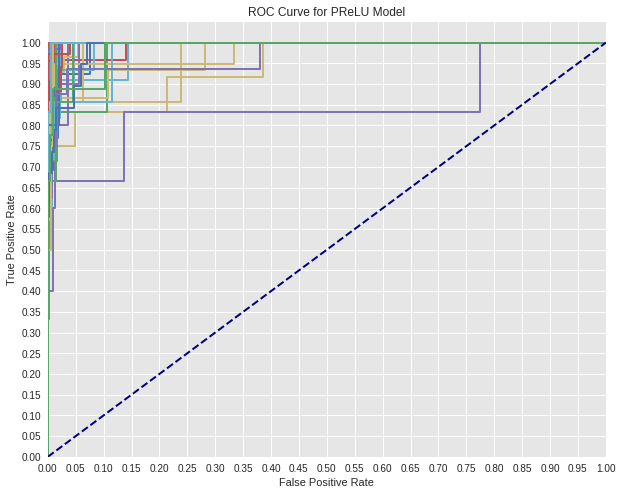

In [0]:
%matplotlib inline
# Plot some of 537 celebs ROC curve 
#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

plt.figure(figsize=(10,8))
lw = 2 # linewidth
for i in range(50):
  plt.plot(fpr[i], tpr[i], lw = lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.yticks([ii/20.0 for ii in range(21)])
  plt.xticks([ii/20.0 for ii in range(21)])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for PReLU Model')
plt.show()

## SeLU Model

In [0]:
# Set seed to get same results
np.random.seed(123)
# Define model as Sequential class
model_selu = Sequential()

In [0]:
model_selu.add(layers.Dense(128, input_shape = (1,193), activation = 'selu'))
model_selu.add(Dropout(rate = 0.1))

model_selu.add(layers.Dense(256, activation = 'selu'))
model_selu.add(layers.Dense(512, activation = 'selu'))
model_selu.add(layers.Dense(512, activation = 'selu'))
model_selu.add(Dropout(rate = 0.1))


model_selu.add(layers.Dense(512, activation = 'selu'))
model_selu.add(layers.Dense(512, activation = 'selu'))
model_selu.add(Dropout(rate = 0.1))

model_selu.add(layers.Dense(256, activation = 'selu'))
model_selu.add(layers.Dense(256, activation = 'selu'))
model_selu.add(Dropout(rate = 0.1))

model_selu.add(layers.Dense(256, activation = 'selu'))
model_selu.add(layers.Dense(256, activation = 'selu'))
model_selu.add(Dropout(rate = 0.1))

model_selu.add(layers.Dense(256, activation = 'selu'))
model_selu.add(layers.Dense(256, activation = 'selu'))
model_selu.add(Dropout(rate = 0.1))

model_selu.add(layers.Dense(256, activation = 'selu'))
model_selu.add(layers.Dense(256, activation = 'selu'))
model_selu.add(Dropout(rate = 0.1))

model_selu.add(layers.Flatten())
model_selu.add(Dense(537, activation = 'softmax'))

In [0]:
opt = Adamax(lr = 1e-3, decay = 1e-5)
model_selu.compile(loss = 'categorical_crossentropy', 
              optimizer = opt,
             metrics = ['accuracy'])

In [0]:
earlystop = EarlyStopping(monitor='val_loss',
                              min_delta=0.001,
                              patience=3,
                              verbose=0, mode='auto')

In [0]:
history = model_selu.fit(x_train_, 
                    y_train_, 
                    epochs = 100, 
                    batch_size = 25,
                    validation_data= (x_val_,y_val_), callbacks = [earlystop])


46427/46427 [==============================] - 26s 564us/step - loss: 0.9875 - acc: 0.7398 - val_loss: 1.6399 - val_acc: 0.6798
Epoch 43/100
46427/46427 [==============================] - 26s 563us/step - loss: 0.9592 - acc: 0.7484 - val_loss: 1.6330 - val_acc: 0.6842


### Errors & Accuracy Plot

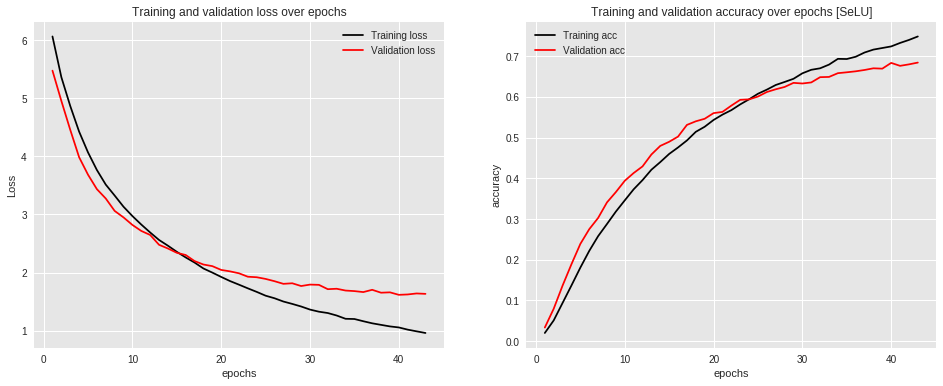

In [0]:
# Look at the history of the model
hist_dense = model_selu.history.history # contains information from fitting model
hist_dense.keys() # returns: dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

# Call each key to get the values to plot
loss_selu = hist_dense['loss'] 
val_loss_selu = hist_dense['val_loss']
acc_selu = hist_dense['acc']
val_acc_selu = hist_dense['val_acc']

epochs = range(1, len(loss_selu) + 1)

# Plot Losses of training and validation sets v. epochs
plt.figure(figsize=(25,6))
plt.subplot(131)
plt.plot(epochs, loss_selu, 'k', label = 'Training loss')
plt.plot(epochs, val_loss_selu, 'r', label = 'Validation loss')

# Add the good stuff                      
plt.title('Training and validation loss over epochs')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy scores over epochs for training and validation sets                      
plt.subplot(132)
plt.plot(epochs, acc_selu, 'k', label='Training acc')
plt.plot(epochs, val_acc_selu, 'r', label= 'Validation acc')

# Add the good stuff                      
plt.title('Training and validation accuracy over epochs [SeLU]')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

### Basic Metrics

In [0]:
# Use model to predict on testing set
y_pred = model_selu.predict(x_test_)

In [0]:
# Convert y_pred from continuous variables to discreet binary (0,1)
yy = []
for elem in y_pred: # each element is an array
  row = []
  for e in elem: # each number in the array
    if e == elem.max(): # since softmax outputs probability...
      row.append(1) # assign highest prob as 1
    else:
      row.append(0) # assign all other probs as 0
  yy.append(row)
y_pred_ = np.array(yy)      

In [0]:
f1_score(y_test_, y_pred_, average= 'weighted') # 0.6930043492601609
precision_score(y_test_, y_pred_, average= 'weighted') # 0.7148270141132256
accuracy_score(y_test_, y_pred_) # 0.6962319739494496
recall_score(y_test_, y_pred_, average= 'weighted') # 0.6962319739494496

0.6962319739494496

### AUC/ROC Curve

In [0]:
# Iterate through y_test_ and y_pred_ to get predictions for each of the 537 IDs
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(y_test_.shape[1]):
  # use y_pred not y_pred_, because the roc_curve function needs probability for threshold metric
  fpr[i], tpr[i], thresholds = roc_curve(y_test_[:,i], y_pred[:,i]) # fpr = false positive rate, tpr = true positive rate
  roc_auc[i] = auc(fpr[i], tpr[i])


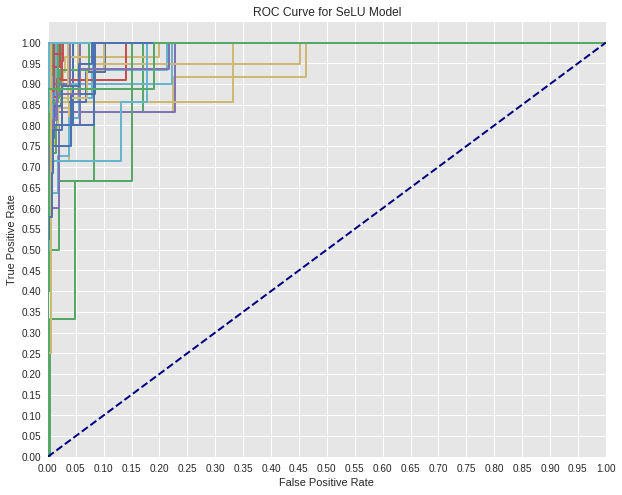

In [0]:
%matplotlib inline
# Plot some of 537 celebs ROC curve 
#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

plt.figure(figsize=(10,8))
lw = 2 # linewidth
for i in range(50):
  plt.plot(fpr[i], tpr[i], lw = lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.yticks([ii/20.0 for ii in range(21)])
  plt.xticks([ii/20.0 for ii in range(21)])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SeLU Model')
plt.show()

## Talos (Disregard)

In [0]:
# Set seed to get same results
np.random.seed(123)

In [0]:
# set parameter space
p = {'first_neuron':[64],
     'num_neurons': [64],
     'hidden_layers':[10,12,15],
     'batch_size': [20],
     'epochs': [25],
     'dropout': [0],
     'alpha': [0.001],
     'advanced_act': [PReLU()],
     'optimizer': ["sgd"],
     'losses': ["categorical_crossentropy"],
     'activation':[relu,elu ],
     'last_activation': [softmax]}

# # set parameter space
# p = {'first_neuron':[64,128],
#      'num_neurons': [64,128,256, 512],
#      'hidden_layers':[10, 11, 12],
#      'batch_size': [20,25,30],
#      'epochs': [25],
#      'dropout': [0],
#      'alpha': [0.001, 0.01],
#      'advanced_act': [PReLU()],
#      'optimizer': ["sgd","Adam"],
#      'losses': ["categorical_crossentropy"],
#      'activation':[relu, elu],
#      'last_activation': [softmax]}

In [0]:
def best_model(x_train, y_train, x_val, y_val, params):
  # Define model as Sequential class
  model = Sequential()
    
  # first layer
  model.add(layers.Dense(params['first_neuron'], 
                           input_shape = (1,193)))
  model.add(PReLU(alpha_initializer='zeros', ))
    
  # possibly add dropout
  model.add(Dropout(params['dropout']))
    
  # add hidden layer
  hidden_layers(model, params, y_train.shape[1])
            
  # add flatten layer for last output layer
  model.add(layers.Flatten())
    
  # add last layer
  model.add(Dense(343, activation = params['last_activation']))
    
  # Compile the model
  model.compile(loss = params['losses'],
                  optimizer = params['optimizer'],
                  metrics = ['acc'])
    
  # Fit the model
  history = model.fit(x_train, y_train, 
                        validation_data = (x_val, y_val),
                        batch_size = params['batch_size'],
                        epochs = params['epochs'],
                        callbacks=[live()],
                        verbose=0)
  return history, model

In [0]:
# run the experiment
t = ta.Scan(x = x_train_,
            y = y_train_,
            x_val = x_test_,
            y_val = y_test_,
            model = best_model,
            params = p,
            experiment_no='1')

In [0]:
type(t)

talos.scan.Scan.Scan

## CNN w/ LeakyReLU

In [0]:
# Set seed to get same results
np.random.seed(123)
# Define model as Sequential class
model_cnn = Sequential()

In [0]:
# Block 1
model_cnn.add(Conv1D(128, (2), strides=(2), padding='same', input_shape = (1,193)))
model_cnn.add(LeakyReLU(alpha=.001)) 
model_cnn.add(MaxPooling1D((2), strides=(2), padding='same'))

# Block 2
model_cnn.add(Conv1D(256, (2), strides=(2), padding='same'))
model_cnn.add(LeakyReLU(alpha=.001)) 
model_cnn.add(MaxPooling1D((2), strides=(2), padding='same'))
model_cnn.add(Dropout(rate = 0.1))

# Block 3
model_cnn.add(Conv1D(512, (2), strides=(2), padding='same'))
model_cnn.add(LeakyReLU(alpha=.001)) 
model_cnn.add(MaxPooling1D((2), strides=(2), padding='same'))

# Block 4
model_cnn.add(Conv1D(512, (2), strides=(2), padding='same'))
model_cnn.add(LeakyReLU(alpha=.001)) 
model_cnn.add(MaxPooling1D((2), strides=(2), padding='same'))
model_cnn.add(Dropout(rate = 0.1))

# Block 5
model_cnn.add(Conv1D(512, (2), strides=(2), padding='same'))
model_cnn.add(LeakyReLU(alpha=.001)) 
model_cnn.add(MaxPooling1D((2), strides=(2), padding='same'))

# Output block
model_cnn.add(layers.Flatten())
model_cnn.add(Dense(537, activation = 'softmax'))


In [0]:
opt = Adam(lr = 1e-3, decay = 1e-5)
model_cnn.compile(loss = 'categorical_crossentropy', 
              optimizer = opt,
             metrics = ['accuracy'])

In [0]:
earlystop = EarlyStopping(monitor='val_loss',
                              min_delta=0.001,
                              patience=5,
                              verbose=0, mode='auto')

In [0]:
history = model_cnn.fit(x_train_, 
                    y_train_, 
                    epochs = 100, 
                    batch_size = 25,
                    validation_data= (x_test_,y_test_), callbacks= [earlystop])


### Errors & Accuracy Plot

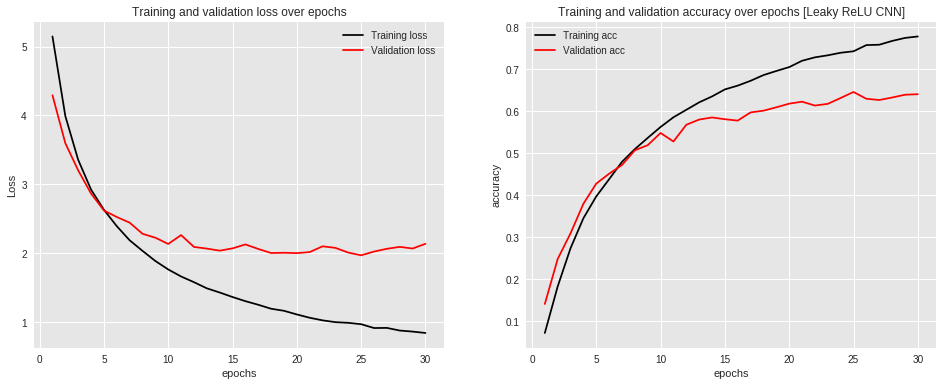

In [0]:
# Look at the history of the model
hist_dense = model_cnn.history.history # contains information from fitting model
hist_dense.keys() # returns: dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

# Call each key to get the values to plot
loss_cnn = hist_dense['loss'] 
val_loss_cnn = hist_dense['val_loss']
acc_cnn = hist_dense['acc']
val_acc_cnn = hist_dense['val_acc']

epochs = range(1, len(loss_cnn) + 1)

# Plot Losses of training and validation sets v. epochs
plt.figure(figsize=(25,6))
plt.subplot(131)
plt.plot(epochs, loss_cnn, 'k', label = 'Training loss')
plt.plot(epochs, val_loss_cnn, 'r', label = 'Validation loss')

# Add the good stuff                      
plt.title('Training and validation loss over epochs')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy scores over epochs for training and validation sets                      
plt.subplot(132)
plt.plot(epochs, acc_cnn, 'k', label='Training acc')
plt.plot(epochs, val_acc_cnn, 'r', label= 'Validation acc')

# Add the good stuff                      
plt.title('Training and validation accuracy over epochs [Leaky ReLU CNN]')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

### Basic Metrics

In [0]:
# Use model to predict on testing set
y_pred = model_cnn.predict(x_test_)

In [0]:
# Convert y_pred from continuous variables to discreet binary (0,1)
yy = []
for elem in y_pred: # each element is an array
  row = []
  for e in elem: # each number in the array
    if e == elem.max(): # since softmax outputs probability...
      row.append(1) # assign highest prob as 1
    else:
      row.append(0) # assign all other probs as 0
  yy.append(row)
y_pred_ = np.array(yy)      

In [0]:
f1_score(y_test_, y_pred_, average= 'weighted') # 0.6385767271678208
precision_score(y_test_, y_pred_, average= 'weighted') # 0.6672402298965948
accuracy_score(y_test_, y_pred_) # 0.6399441773918437
recall_score(y_test_, y_pred_, average= 'weighted') # 0.6399441773918437

0.6399441773918437

### AUC/ROC Curve

In [0]:
# Iterate through y_test_ and y_pred_ to get predictions for each of the 537 IDs
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(y_test_.shape[1]):
  # use y_pred not y_pred_, because the roc_curve function needs probability for threshold metric
  fpr[i], tpr[i], thresholds = roc_curve(y_test_[:,i], y_pred[:,i]) # fpr = false positive rate, tpr = true positive rate
  roc_auc[i] = auc(fpr[i], tpr[i])


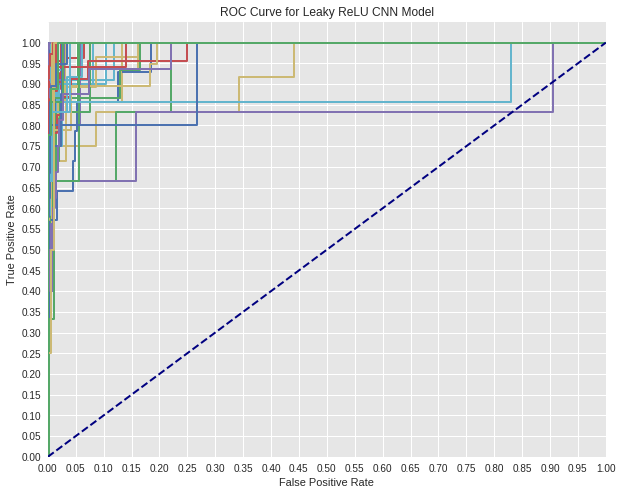

In [0]:
%matplotlib inline
# Plot some of 537 celebs ROC curve 
#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

plt.figure(figsize=(10,8))
lw = 2 # linewidth
for i in range(50):
  plt.plot(fpr[i], tpr[i], lw = lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.yticks([ii/20.0 for ii in range(21)])
  plt.xticks([ii/20.0 for ii in range(21)])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Leaky ReLU CNN Model')
plt.show()

## CNN  w/ PReLU

In [0]:
# Set seed to get same results
np.random.seed(121)
# Define model as Sequential class
model_cnnpl = Sequential()

In [0]:
# Block 1
model_cnnpl.add(Conv1D(128, (2), strides=(2), padding='same', input_shape = (1,193)))
model_cnnpl.add(PReLU())
model_cnnpl.add(MaxPooling1D((2), strides=(2), padding='same'))

# Block 2
model_cnnpl.add(Conv1D(256, (2), strides=(2), padding='same'))
model_cnnpl.add(PReLU())
model_cnnpl.add(MaxPooling1D((2), strides=(2), padding='same'))
model_cnnpl.add(Dropout(rate = 0.1))

# Block 3
model_cnnpl.add(Conv1D(512, (2), strides=(2), padding='same'))
model_cnnpl.add(PReLU())
model_cnnpl.add(MaxPooling1D((2), strides=(2), padding='same'))

# Block 4
model_cnnpl.add(Conv1D(512, (2), strides=(2), padding='same'))
model_cnnpl.add(PReLU())
model_cnnpl.add(MaxPooling1D((2), strides=(2), padding='same'))
model_cnnpl.add(Dropout(rate = 0.1))

# Block 5
model_cnnpl.add(Conv1D(512, (2), strides=(2), padding='same'))
model_cnnpl.add(PReLU())
model_cnnpl.add(MaxPooling1D((2), strides=(2), padding='same'))

# Block 6
model_cnnpl.add(Conv1D(256, (2), strides=(2), padding='same'))
model_cnnpl.add(PReLU())
model_cnnpl.add(MaxPooling1D((2), strides=(2), padding='same'))

# Block 7
model_cnnpl.add(Conv1D(256, (2), strides=(2), padding='same'))
model_cnnpl.add(PReLU())
model_cnnpl.add(MaxPooling1D((2), strides=(2), padding='same'))

# FC block
model_cnnpl.add(layers.Flatten())
model_cnnpl.add(Dense(537, activation = 'softmax'))


In [0]:
opt = Adamax(lr = 1e-3, decay = 1e-5)
model_cnnpl.compile(loss = 'categorical_crossentropy', 
              optimizer = opt,
             metrics = ['accuracy'])

In [0]:
earlystop = EarlyStopping(monitor='val_loss',
                              min_delta=0.001,
                              patience=3,
                              verbose=0, mode='auto')

In [0]:
history = model_cnnpl.fit(x_train_, 
                    y_train_, 
                    epochs = 100, 
                    batch_size = 25,
                    validation_data= (x_test_,y_test_), callbacks = [earlystop])


### Errors & Accuracy Plot

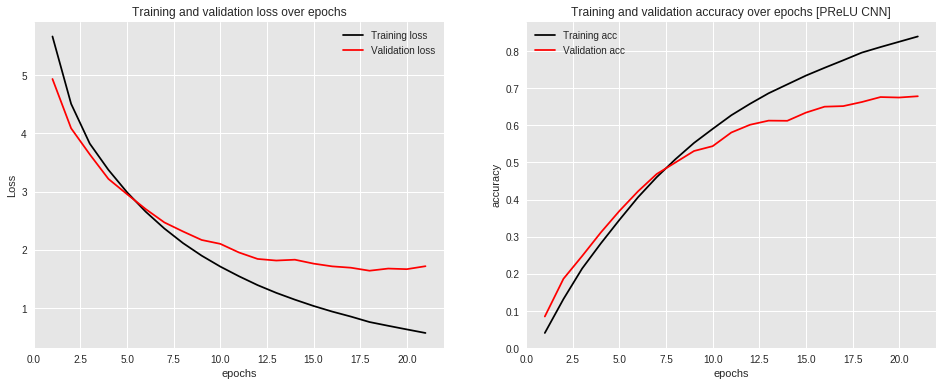

In [0]:
# Look at the history of the model
hist_dense = model_cnnpl.history.history # contains information from fitting model
hist_dense.keys() # returns: dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

# Call each key to get the values to plot
loss_cnnpl = hist_dense['loss'] 
val_loss_cnnpl = hist_dense['val_loss']
acc_cnnpl = hist_dense['acc']
val_acc_cnnpl = hist_dense['val_acc']

epochs = range(1, len(loss_cnnpl) + 1)

# Plot Losses of training and validation sets v. epochs
plt.figure(figsize=(25,6))
plt.subplot(131)
plt.plot(epochs, loss_cnnpl, 'k', label = 'Training loss')
plt.plot(epochs, val_loss_cnnpl, 'r', label = 'Validation loss')

# Add the good stuff                      
plt.title('Training and validation loss over epochs')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy scores over epochs for training and validation sets                      
plt.subplot(132)
plt.plot(epochs, acc_cnnpl, 'k', label='Training acc')
plt.plot(epochs, val_acc_cnnpl, 'r', label= 'Validation acc')

# Add the good stuff                      
plt.title('Training and validation accuracy over epochs [PReLU CNN]')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

### Basic Metrics

In [0]:
# Use model to predict on testing set
y_pred = model_cnnpl.predict(x_test_)

In [0]:
# Convert y_pred from continuous variables to discreet binary (0,1)
yy = []
for elem in y_pred: # each element is an array
  row = []
  for e in elem: # each number in the array
    if e == elem.max(): # since softmax outputs probability...
      row.append(1) # assign highest prob as 1
    else:
      row.append(0) # assign all other probs as 0
  yy.append(row)
y_pred_ = np.array(yy)      

In [0]:
f1_score(y_test_, y_pred_, average= 'weighted') # 0.6753212975691832
precision_score(y_test_, y_pred_, average= 'weighted') # 0.708424003115032
accuracy_score(y_test_, y_pred_) # 0.678089626298651
recall_score(y_test_, y_pred_, average= 'weighted') # 0.678089626298651

0.678089626298651

### AUC/ROC Curve

In [0]:
# Iterate through y_test_ and y_pred_ to get predictions for each of the 537 IDs
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(y_test_.shape[1]):
  # use y_pred not y_pred_, because the roc_curve function needs probability for threshold metric
  fpr[i], tpr[i], thresholds = roc_curve(y_test_[:,i], y_pred[:,i]) # fpr = false positive rate, tpr = true positive rate
  roc_auc[i] = auc(fpr[i], tpr[i])


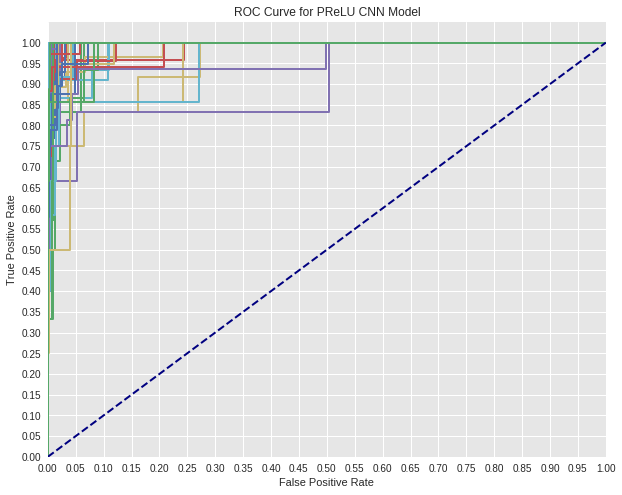

In [0]:
%matplotlib inline
# Plot some of 537 celebs ROC curve 
#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

plt.figure(figsize=(10,8))
lw = 2 # linewidth
for i in range(50):
  plt.plot(fpr[i], tpr[i], lw = lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.yticks([ii/20.0 for ii in range(21)])
  plt.xticks([ii/20.0 for ii in range(21)])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for PReLU CNN Model')
plt.show()

## CNN w/ SeLU (Best Model)

In [0]:
# Set seed to get same results
np.random.seed(121)
# Define model as Sequential class
model_cnn_selu = Sequential()

In [0]:
# Block 1

# first layer: convolutional layer with filter size of 2 and strid of 2, due to 
# the features having shape divisable by 2. selu shown to work better than relu
# and leaky relu without CNN.
# Max Pool to get only the important features
# add dropout to combat overfitting. rate = 10% of neurons to drop
model_cnn_selu.add(Conv1D(128, (2), strides=(2), padding='same', 
                     input_shape = (1,193), activation= 'selu'))
model_cnn_selu.add(MaxPooling1D((2), strides=(2), padding='same'))
model_cnn_selu.add(Dropout(rate = 0.1))

# Block 2
model_cnn_selu.add(Conv1D(256, (2), strides=(2), padding='same', activation= 'selu'))
model_cnn_selu.add(MaxPooling1D((2), strides=(2), padding='same'))
model_cnn_selu.add(Dropout(rate = 0.1))

# Block 3
model_cnn_selu.add(Conv1D(256, (2), strides=(2), padding='same', activation= 'selu'))
model_cnn_selu.add(Conv1D(512, (2), strides=(2), padding='same',activation= 'selu'))
model_cnn_selu.add(MaxPooling1D((2), strides=(2), padding='same'))

# Block 4
model_cnn_selu.add(Conv1D(512, (2), strides=(2), padding='same', activation= 'selu'))
model_cnn_selu.add(MaxPooling1D((2), strides=(2), padding='same'))
model_cnn_selu.add(Dropout(rate = 0.1))

# Block 5
model_cnn_selu.add(Conv1D(512, (2), strides=(2), padding='same',activation= 'selu'))
model_cnn_selu.add(MaxPooling1D((2), strides=(2), padding='same'))

# Block 7
model_cnn_selu.add(Conv1D(256, (2), strides=(2), padding='same', activation= 'selu'))
model_cnn_selu.add(MaxPooling1D((2), strides=(2), padding='same'))

# Block 8 
model_cnn_selu.add(Conv1D(256, (2), strides=(2), padding='same', activation= 'selu'))
model_cnn_selu.add(MaxPooling1D((2), strides=(2), padding='same'))
model_cnn_selu.add(Dropout(rate = 0.1))

# Block 9
model_cnn_selu.add(Conv1D(256, (2), strides=(2), padding='same', activation= 'selu'))
model_cnn_selu.add(MaxPooling1D((2), strides=(2), padding='same'))

# Output Block
model_cnn_selu.add(layers.Flatten())
model_cnn_selu.add(Dense(537, activation = 'softmax'))


In [0]:
# Compile the model with a specified Adamax optimizer
opt = Adamax(lr = 1e-3, decay = 1e-5) # Adamax has shown to yield faster learning than Adam and SGD
model_cnn_selu.compile(loss = 'categorical_crossentropy', 
              optimizer = opt,
             metrics = ['accuracy'])

In [0]:
# Add automated stopping after val_loss difference from epoch t and t-1 is 
# more than 0.001; give it three more epochs to try and get back on track (patience)
earlystop = EarlyStopping(monitor='val_loss',
                              min_delta=0.001,
                              patience=3,
                              verbose=0, mode='auto')

In [0]:
# fit the data and save it with history variable. 
history = model_cnn_selu.fit(x_train_, 
                    y_train_, 
                    epochs = 100, 
                    batch_size = 25,
                    validation_data= (x_val_,y_val_), callbacks = [earlystop])


46427/46427 [==============================] - 33s 708us/step - loss: 0.7676 - acc: 0.7881 - val_loss: 1.4352 - val_acc: 0.7118
Epoch 20/100
46427/46427 [==============================] - 33s 711us/step - loss: 0.7049 - acc: 0.8018 - val_loss: 1.4556 - val_acc: 0.7138
Epoch 21/100
46427/46427 [==============================] - 33s 708us/step - loss: 0.6802 - acc: 0.8077 - val_loss: 1.4141 - val_acc: 0.7190
Epoch 22/100
46427/46427 [==============================] - 33s 711us/step - loss: 0.6433 - acc: 0.8178 - val_loss: 1.4173 - val_acc: 0.7233
Epoch 23/100
46427/46427 [==============================] - 33s 710us/step - loss: 0.6072 - acc: 0.8285 - val_loss: 1.4263 - val_acc: 0.7281
Epoch 24/100
46427/46427 [==============================] - 33s 716us/step - loss: 0.5658 - acc: 0.8350 - val_loss: 1.4368 - val_acc: 0.7281


In [0]:
# Save best model so don't have to rerun in scenario of crash
model_json = model_cnn_selu.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
    
model_cnn.save_weights("model_weights.h5")
print("Saved model to drive")

Saved model to drive


In [0]:
# # Read in model
# json_file = open('model.json', 'r')
# loaded_model_json = json_file.read()

# json_file.close()
# loaded_model = model_from_json(loaded_model_json)

# # load weights into new model
# loaded_model.load_weights("model_weights.h5")
# print("Loaded model into notebook")

In [0]:
# # Compile the model with a specified Adamax optimizer
# opt = Adamax(lr = 1e-3, decay = 1e-5) # Adamax has shown to yield faster learning than Adam and SGD
# loaded_model.compile(loss = 'categorical_crossentropy', 
#               optimizer = opt,
#              metrics = ['accuracy'])

### Errors & Accuracy Plot

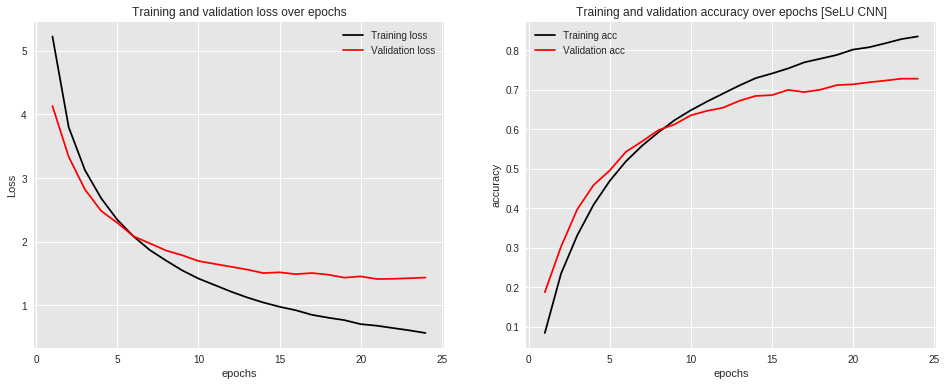

In [0]:
# Look at the history of the model
hist_dense = model_cnn_selu.history.history # contains information from fitting model
hist_dense.keys() # returns: dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

# Call each key to get the values to plot
loss_cnn_selu = hist_dense['loss'] 
val_loss_cnn_selu = hist_dense['val_loss']
acc_cnn_selu = hist_dense['acc']
val_acc_cnn_selu = hist_dense['val_acc']

epochs = range(1, len(loss_cnn_selu) + 1)

# Plot Losses of training and validation sets v. epochs
plt.figure(figsize=(25,6))
plt.subplot(131)
plt.plot(epochs, loss_cnn_selu, 'k', label = 'Training loss')
plt.plot(epochs, val_loss_cnn_selu, 'r', label = 'Validation loss')

# Add the good stuff                      
plt.title('Training and validation loss over epochs')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy scores over epochs for training and validation sets                      
plt.subplot(132)
plt.plot(epochs, acc_cnn_selu, 'k', label='Training acc')
plt.plot(epochs, val_acc_cnn_selu, 'r', label= 'Validation acc')

# Add the good stuff                      
plt.title('Training and validation accuracy over epochs [SeLU CNN]')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.show()

### Basic Metrics

In [0]:
# Use model to predict on testing set
y_pred = model_cnn_selu.predict(x_test_)


In [0]:
# Convert y_pred from continuous variables to discreet binary (0,1)
yy = []
for elem in y_pred: # each element is an array
  row = []
  for e in elem: # each number in the array
    if e == elem.max(): # since softmax outputs probability...
      row.append(1) # assign highest prob as 1
    else:
      row.append(0) # assign all other probs as 0
  yy.append(row)
y_pred_ = np.array(yy)      

In [0]:
f1_score(y_test_, y_pred_, average= 'weighted') # 0.7299842196935593
precision_score(y_test_, y_pred_, average= 'weighted') # 0.7503546303263359
accuracy_score(y_test_, y_pred_) # 0.732826794851915
recall_score(y_test_, y_pred_, average= 'weighted') # 0.732826794851915

0.732826794851915

### AUC/ROC Curve

In [0]:
# Iterate through y_test_ and y_pred_ to get auc value for each of the 537 IDs
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(y_test_.shape[1]):
  # use y_pred not y_pred_, because the roc_curve function needs probability for threshold metric
  fpr[i], tpr[i], thresholds = roc_curve(y_test_[:,i], y_pred[:,i]) # fpr = false positive rate, tpr = true positive rate
  roc_auc[i] = auc(fpr[i], tpr[i])


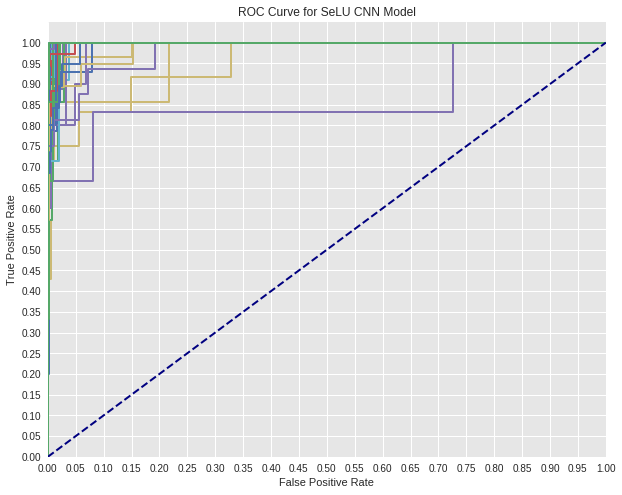

In [0]:
%matplotlib inline
# Plot some of 537 celebs ROC curve 
#Seaborns Beautiful Styling
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

plt.figure(figsize=(10,8))
lw = 2 # linewidth
for i in range(50):
  plt.plot(fpr[i], tpr[i], lw = lw)
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.yticks([ii/20.0 for ii in range(21)])
  plt.xticks([ii/20.0 for ii in range(21)])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for SeLU CNN Model')
plt.show()

In [0]:
# # Confusion matrix for multiple labels:
# def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix',cmap = plt.cm.Blues):
    
#     #Add Normalization Option
#     '''prints pretty confusion metric with normalization option '''
#     if normalize:
#         cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')
    
#     # Plot
#     plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
#     tick_marks = np.arange(len(classes))
#     plt.xticks(tick_marks, classes, rotation=45)
#     plt.yticks(tick_marks, classes)
    
#     fmt = '.2f' if normalize else 'd'
#     thresh = cm.max() / 2.
#     for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
#         plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
    
#     plt.tight_layout()
#     plt.ylabel('True label')
#     plt.xlabel('Predicted label')

In [0]:
# # Get Confusion matrix
# cm_ = confusion_matrix(y_test_.argmax(axis = 1), y_pred_.argmax(axis = 1))
# classes_ = df.id
# plot_confusion_matrix(cm_, classes = classes_, normalize=True, \
#                       title='Non-normalized confusion matrix')

Normalized confusion matrix


# Sum Up

## EDA

In [0]:
# Convert meta_df id column into integers like df columns
meta_df.id = meta_df.id.apply(lambda x: int(x[2:]))

In [27]:
meta_df.head()

,id,name,gender,nationality,set
0,10001,A.J._Buckley,m,Ireland,dev
1,10002,A.R._Rahman,m,India,dev
2,10003,Aamir_Khan,m,India,dev
3,10004,Aaron_Tveit,m,USA,dev
4,10005,Aaron_Yoo,m,USA,dev


In [33]:
df.shape # (64483, 194)
full_df = df.merge(meta_df, how = 'left', on = 'id')
full_df.shape # (64483, 198)

(64483, 198)

In [0]:
# Save merged dataframes to pickle file
# full_df.to_pickle("full_df.pkl")

# Read in pickled file
full_df = pd.read_pickle('full_df.pkl')

In [11]:
full_df.head()

,id,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,...,tonnetz,tonnetz,tonnetz,tonnetz,tonnetz,tonnetz,name,gender,nationality,set
0,10332,-274.717176,124.096613,-57.174884,47.091800,-31.190586,-3.631755,-34.891319,-4.590279,-0.825808,...,0.004705,0.003553,-0.009748,0.026007,0.001958,-0.009467,Gemma_Atkinson,f,UK,dev
1,10332,-263.282737,110.169695,-37.532975,49.808548,-30.783113,4.530054,-34.272742,-0.396505,2.088190,...,-0.008559,0.001090,-0.052647,0.053715,-0.014433,-0.001219,Gemma_Atkinson,f,UK,dev
2,10332,-255.330134,107.140581,-37.526152,66.718413,-25.090227,5.835736,-34.682863,0.156228,0.196809,...,-0.000381,0.004534,0.003975,0.063643,-0.003111,-0.009005,Gemma_Atkinson,f,UK,dev
3,10332,-238.647293,116.777418,-43.337226,57.847068,-29.790134,4.556106,-29.883005,-1.273415,0.166903,...,-0.015756,-0.000640,0.002584,0.037222,-0.006243,0.002152,Gemma_Atkinson,f,UK,dev
4,10332,-253.325462,110.840374,-47.403615,46.822241,-28.057003,5.674004,-26.317193,-0.719588,1.632264,...,-0.006521,0.009226,0.008907,0.020127,0.001455,0.002741,Gemma_Atkinson,f,UK,dev


In [12]:
# Binarize gender column
le_gender = LabelEncoder()
full_df.gender = le_gender.fit_transform(full_df.gender)
full_df.gender.unique() # array([0, 1])
full_df.head()

,id,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,...,tonnetz,tonnetz,tonnetz,tonnetz,tonnetz,tonnetz,name,gender,nationality,set
0,10332,-274.717176,124.096613,-57.174884,47.091800,-31.190586,-3.631755,-34.891319,-4.590279,-0.825808,...,0.004705,0.003553,-0.009748,0.026007,0.001958,-0.009467,Gemma_Atkinson,0,UK,dev
1,10332,-263.282737,110.169695,-37.532975,49.808548,-30.783113,4.530054,-34.272742,-0.396505,2.088190,...,-0.008559,0.001090,-0.052647,0.053715,-0.014433,-0.001219,Gemma_Atkinson,0,UK,dev
2,10332,-255.330134,107.140581,-37.526152,66.718413,-25.090227,5.835736,-34.682863,0.156228,0.196809,...,-0.000381,0.004534,0.003975,0.063643,-0.003111,-0.009005,Gemma_Atkinson,0,UK,dev
3,10332,-238.647293,116.777418,-43.337226,57.847068,-29.790134,4.556106,-29.883005,-1.273415,0.166903,...,-0.015756,-0.000640,0.002584,0.037222,-0.006243,0.002152,Gemma_Atkinson,0,UK,dev
4,10332,-253.325462,110.840374,-47.403615,46.822241,-28.057003,5.674004,-26.317193,-0.719588,1.632264,...,-0.006521,0.009226,0.008907,0.020127,0.001455,0.002741,Gemma_Atkinson,0,UK,dev


In [13]:
# Label Encode nationality column
le_nationality = LabelEncoder()
full_df.nationality = le_nationality.fit_transform(full_df.nationality)
full_df.nationality.unique()
full_df.head()
# le_nationality.classes_

,id,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,mfcc,...,tonnetz,tonnetz,tonnetz,tonnetz,tonnetz,tonnetz,name,gender,nationality,set
0,10332,-274.717176,124.096613,-57.174884,47.091800,-31.190586,-3.631755,-34.891319,-4.590279,-0.825808,...,0.004705,0.003553,-0.009748,0.026007,0.001958,-0.009467,Gemma_Atkinson,0,22,dev
1,10332,-263.282737,110.169695,-37.532975,49.808548,-30.783113,4.530054,-34.272742,-0.396505,2.088190,...,-0.008559,0.001090,-0.052647,0.053715,-0.014433,-0.001219,Gemma_Atkinson,0,22,dev
2,10332,-255.330134,107.140581,-37.526152,66.718413,-25.090227,5.835736,-34.682863,0.156228,0.196809,...,-0.000381,0.004534,0.003975,0.063643,-0.003111,-0.009005,Gemma_Atkinson,0,22,dev
3,10332,-238.647293,116.777418,-43.337226,57.847068,-29.790134,4.556106,-29.883005,-1.273415,0.166903,...,-0.015756,-0.000640,0.002584,0.037222,-0.006243,0.002152,Gemma_Atkinson,0,22,dev
4,10332,-253.325462,110.840374,-47.403615,46.822241,-28.057003,5.674004,-26.317193,-0.719588,1.632264,...,-0.006521,0.009226,0.008907,0.020127,0.001455,0.002741,Gemma_Atkinson,0,22,dev


In [14]:
id10332_df = full_df[full_df.id == 10332]
id10332_mfcc = id10332_df.mfcc
id10332_mfcc.iloc[1,:]
ax = sns.scatterplot(x = len(id10332_mfcc.columns), y = id10332_mfcc.iloc[1,:])

AttributeError: ignored

<function matplotlib.pyplot.show>

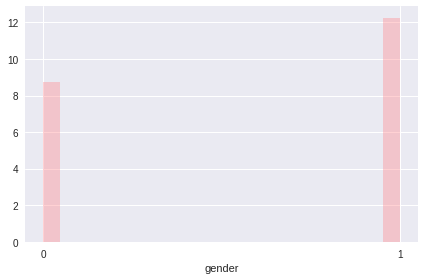

In [18]:
%matplotlib inline
ax = sns.distplot(full_df["gender"], hist = True, kde = False, color = '#ff8c91',
             norm_hist = True, label = 'female')
ax.set(xticks = full_df.gender.unique())
plt.tight_layout()
plt.show

In [37]:
full_df.name.unique()

array(['Gemma_Atkinson', 'Keri_Hilson', 'Dyan_Cannon', 'Carrie_Fisher',
       'Jeremy_Renner', 'Daniel_Craig', 'Brett_Davern',
       'Katheryn_Winnick', 'Katee_Sackhoff', 'Chris_Hemsworth',
       'Josh_Henderson', 'Donna_Murphy', 'Luke_Evans', 'Dreama_Walker',
       'Daniel_Auteuil', 'Carrie_Ann_Inaba', 'Irrfan_Khan',
       'Kristen_Wiig', 'Hannah_Spearritt', 'Lou_Diamond_Phillips',
       'Kenya_Moore', 'Keeley_Hawes', 'Mathilda_May', 'Jon_Lovitz',
       'Drea_de_Matteo', 'Jessie_J', 'Brenda_Blethyn', 'Hannah_Simone',
       'Jessica_Lowndes', 'Lotte_Verbeek', 'Carolyn_Hennesy',
       'Jon_Huertas', 'Diego_Klattenhoff', 'Hal_Sparks', 'Ingrid_Bergman',
       'Dana_Delany', 'Janice_Dickinson', 'Chloe_Bennet', 'Armie_Hammer',
       'Kate_Mulgrew', 'Bradley_Steven_Perry', 'Geena_Davis',
       'Hailee_Steinfeld', 'Janet_Montgomery', 'Jeremy_Irons',
       'Kristen_Stewart', 'Josh_Groban', 'Ben_McKenzie', 'Keegan_Allen',
       'Drake_Bell', 'Jon_Favreau', 'Indira_Varma', 'Armand_

#Stuff below is irrelevant to this project

## Concatenate the file clips into full videos

According to the article the final dataset consists of 121 videos including 61 deceptive and 60 truthful trial clips. The videos are written in the format 'trial_lie_001_000.mp4' - 'trial_lie_001_004.mp4' and 'trial_truth_041_000.mp4' - 'trial_truth_041_008.mp4'. The exact number of chunks per video is unknown.

In [0]:
# Get the filenames in the directory: video_chunks
files = [f for f in listdir('video_chunks/') if isfile(join('video_chunks/',f))]
files.pop(0) # .DS_Store is first element in the list, don't need this

In [0]:
print(len(files)) # 829. matches how many video files I have in my directory 
files

In [0]:
# Split files list into truth list and lie list
truth = 'trial_truth_'
lie = 'trial_lie_'
truth_list = list(filter(lambda file: file.startswith(truth),files))
lie_list = list(filter(lambda file: file.startswith(lie),files))

In [0]:
# Format list into dictionary
lie_dict = {}
for file in lie_list:
    try: 
        lie_dict[file[10:13]]: lie_dict[file[10:13]].append(file) # append filename to appropriate key
    except:
        lie_dict[file[10:13]] = [] # create key with value as empty list
        lie_dict[file[10:13]]: lie_dict[file[10:13]].append(file) # append filename to appropriate key

truth_dict = {}
for file in truth_list:
    try: 
        truth_dict[file[12:15]]: truth_dict[file[12:15]].append(file)
    except:
        truth_dict[file[12:15]] = []
        truth_dict[file[12:15]]: truth_dict[file[12:15]].append(file)  

In [0]:
# Concat truth videos and save them in a new folder
# Had to restart kernel and start at stopping point because the error was OSError: [Errno 24] Too many open files'

try:
    for key in list(truth_dict.keys())[49:]: # There are 50 keys in the list. some numbers are skipped
        vids = [VideoFileClip("Video_chunks/{}".format(clip)) for clip in truth_dict[key]] # read each clip, save as list of clips
        full_video = concatenate_videoclips(vids) # put all the chunks together to one video
        name = truth_dict[key][0][:15] # call it the appropriate name
        full_video.write_videofile('videos/'+name+'.mp4') # write the full video and save in a diff. folder
except OSError:
    print('stopped at index: {}'.format(list(truth_dict.keys()).index(key)))
    # Clear the kernel and change the first line of try to start at the index it failed on

In [0]:
# Concat lie videos and save them in a new folder
# Had to restart kernel and start at stopping point because the error was OSError: [Errno 24] Too many open files'

try:
    for key in list(lie_dict.keys())[55:]: # There are 61 keys in the list. some numbers are skipped
        vids = [VideoFileClip("Video_chunks/{}".format(clip)) for clip in lie_dict[key]] # read each clip, save as list of clips
        full_video = concatenate_videoclips(vids) # put all the chunks together to one video
        name = lie_dict[key][0][:13] # call it the appropriate name
        full_video.write_videofile('videos/'+name+'.mp4') # write the full video and save in a diff. folder
except OSError:
    print('stopped at index: {}'.format(list(lie_dict.keys()).index(key)))
    # Clear the kernel and change the first line of try to start at the index it failed on

## Get audio from each video

In [0]:
# Get the filenames in the directory: video_chunks
videos = [f for f in listdir('videos/')]
videos.pop(0)# .DS_Store is first element in the list, don't need this. 109 videos in total

'.DS_Store'

In [0]:
# Write audio files from videos and save it in the empty audio file
for video in videos:
    vid = VideoFileClip('videos/'+video)
    name = video[:-4]
    vid.audio.write_audiofile("audio/"+name+".wav") # name the audio file like its corresponding video, minus the .mp4
    

[MoviePy] Writing audio in audio/trial_lie_001.wav


100%|██████████| 377/377 [00:00<00:00, 2556.18it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_002.wav


100%|██████████| 1381/1381 [00:00<00:00, 2868.92it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_003.wav


100%|██████████| 158/158 [00:00<00:00, 2634.74it/s]

[MoviePy] Done.
[MoviePy] Writing audio in audio/trial_lie_004.wav



100%|██████████| 258/258 [00:00<00:00, 2719.71it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_005.wav


100%|██████████| 1181/1181 [00:00<00:00, 2720.25it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_006.wav


100%|██████████| 404/404 [00:00<00:00, 2714.65it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_007.wav


100%|██████████| 1034/1034 [00:00<00:00, 2861.60it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_008.wav


100%|██████████| 163/163 [00:00<00:00, 2695.55it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_009.wav


100%|██████████| 457/457 [00:00<00:00, 2391.07it/s]


[MoviePy] Done.
[MoviePy] Writing audio in audio/trial_lie_010.wav


100%|██████████| 646/646 [00:00<00:00, 2867.08it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_011.wav


100%|██████████| 745/745 [00:00<00:00, 2855.76it/s]


[MoviePy] Done.
[MoviePy] Writing audio in audio/trial_lie_012.wav


100%|██████████| 176/176 [00:00<00:00, 2625.41it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_013.wav


100%|██████████| 422/422 [00:00<00:00, 2685.66it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_014.wav


100%|██████████| 335/335 [00:00<00:00, 2467.03it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_015.wav


100%|██████████| 778/778 [00:00<00:00, 2831.39it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_016.wav


100%|██████████| 833/833 [00:00<00:00, 2721.75it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_017.wav


100%|██████████| 1000/1000 [00:00<00:00, 2502.58it/s]


[MoviePy] Done.
[MoviePy] Writing audio in audio/trial_lie_018.wav


100%|██████████| 773/773 [00:00<00:00, 2681.49it/s]


[MoviePy] Done.
[MoviePy] Writing audio in audio/trial_lie_019.wav


100%|██████████| 823/823 [00:00<00:00, 2785.83it/s]


[MoviePy] Done.
[MoviePy] Writing audio in audio/trial_lie_020.wav


100%|██████████| 271/271 [00:00<00:00, 2758.04it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_021.wav


100%|██████████| 421/421 [00:00<00:00, 2740.55it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_022.wav


100%|██████████| 939/939 [00:00<00:00, 2810.95it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_023.wav


100%|██████████| 994/994 [00:00<00:00, 2861.38it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_024.wav


100%|██████████| 564/564 [00:00<00:00, 2743.41it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_025.wav


100%|██████████| 668/668 [00:00<00:00, 2808.90it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_026.wav


100%|██████████| 642/642 [00:00<00:00, 2799.23it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_027.wav


100%|██████████| 611/611 [00:00<00:00, 2835.29it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_028.wav


100%|██████████| 559/559 [00:00<00:00, 2859.13it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_029.wav


100%|██████████| 476/476 [00:00<00:00, 2827.53it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_030.wav


100%|██████████| 839/839 [00:00<00:00, 2690.62it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_031.wav


100%|██████████| 593/593 [00:00<00:00, 2863.21it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_033.wav


100%|██████████| 997/997 [00:00<00:00, 2853.74it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_035.wav


100%|██████████| 779/779 [00:00<00:00, 2923.37it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_036.wav


100%|██████████| 864/864 [00:00<00:00, 2998.00it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_037.wav


100%|██████████| 577/577 [00:00<00:00, 2977.31it/s]


[MoviePy] Done.
[MoviePy] Writing audio in audio/trial_lie_038.wav


100%|██████████| 511/511 [00:00<00:00, 2902.50it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_039.wav


100%|██████████| 666/666 [00:00<00:00, 2993.57it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_040.wav


100%|██████████| 533/533 [00:00<00:00, 2947.86it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_041.wav


100%|██████████| 576/576 [00:00<00:00, 2907.48it/s]


[MoviePy] Done.
[MoviePy] Writing audio in audio/trial_lie_042.wav


100%|██████████| 532/532 [00:00<00:00, 3004.38it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_043.wav


100%|██████████| 313/313 [00:00<00:00, 2812.11it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_044.wav


100%|██████████| 202/202 [00:00<00:00, 2602.46it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_045.wav


100%|██████████| 423/423 [00:00<00:00, 2702.84it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_046.wav


100%|██████████| 732/732 [00:00<00:00, 2933.33it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_047.wav


100%|██████████| 357/357 [00:00<00:00, 2607.00it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_048.wav


100%|██████████| 1063/1063 [00:00<00:00, 2890.64it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_049.wav


100%|██████████| 511/511 [00:00<00:00, 2938.05it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_050.wav


100%|██████████| 555/555 [00:00<00:00, 2816.27it/s]


[MoviePy] Done.
[MoviePy] Writing audio in audio/trial_lie_051.wav


100%|██████████| 158/158 [00:00<00:00, 3011.41it/s]

[MoviePy] Done.
[MoviePy] Writing audio in audio/trial_lie_052.wav



100%|██████████| 1062/1062 [00:00<00:00, 2928.09it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_053.wav


100%|██████████| 801/801 [00:00<00:00, 2926.85it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_054.wav


100%|██████████| 445/445 [00:00<00:00, 2847.16it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_055.wav


100%|██████████| 709/709 [00:00<00:00, 2828.44it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_056.wav


100%|██████████| 643/643 [00:00<00:00, 2856.27it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_057.wav


100%|██████████| 423/423 [00:00<00:00, 2685.23it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_058.wav


100%|██████████| 489/489 [00:00<00:00, 2880.40it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_059.wav


100%|██████████| 886/886 [00:00<00:00, 2894.20it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_lie_060.wav


100%|██████████| 555/555 [00:00<00:00, 2836.39it/s]


[MoviePy] Done.
[MoviePy] Writing audio in audio/trial_lie_061.wav


100%|██████████| 643/643 [00:00<00:00, 2859.00it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_001.wav


100%|██████████| 317/317 [00:00<00:00, 2602.97it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_002.wav


100%|██████████| 458/458 [00:00<00:00, 2650.65it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_003.wav


100%|██████████| 283/283 [00:00<00:00, 2732.29it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_004.wav


100%|██████████| 1799/1799 [00:00<00:00, 2740.74it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_005.wav


100%|██████████| 769/769 [00:00<00:00, 2829.13it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_006.wav


100%|██████████| 677/677 [00:00<00:00, 2802.87it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_007.wav


100%|██████████| 1581/1581 [00:00<00:00, 2538.85it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_008.wav


100%|██████████| 1011/1011 [00:00<00:00, 2829.56it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_009.wav


100%|██████████| 504/504 [00:00<00:00, 2551.01it/s]


[MoviePy] Done.
[MoviePy] Writing audio in audio/trial_truth_010.wav


100%|██████████| 1615/1615 [00:00<00:00, 2792.21it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_011.wav


100%|██████████| 945/945 [00:00<00:00, 2904.07it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_012.wav


100%|██████████| 635/635 [00:00<00:00, 2655.05it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_013.wav


100%|██████████| 653/653 [00:00<00:00, 2801.32it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_014.wav


100%|██████████| 304/304 [00:00<00:00, 2821.64it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_015.wav


100%|██████████| 820/820 [00:00<00:00, 2874.90it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_016.wav


100%|██████████| 169/169 [00:00<00:00, 2677.53it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_017.wav


100%|██████████| 103/103 [00:00<00:00, 2623.54it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_018.wav


100%|██████████| 157/157 [00:00<00:00, 3140.24it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_019.wav


100%|██████████| 289/289 [00:00<00:00, 2676.39it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_020.wav


100%|██████████| 156/156 [00:00<00:00, 2761.83it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_021.wav


100%|██████████| 243/243 [00:00<00:00, 2830.16it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_022.wav


100%|██████████| 633/633 [00:00<00:00, 2834.64it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_023.wav


100%|██████████| 520/520 [00:00<00:00, 2772.05it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_024.wav


100%|██████████| 536/536 [00:00<00:00, 2814.76it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_025.wav


100%|██████████| 787/787 [00:00<00:00, 2660.04it/s]


[MoviePy] Done.
[MoviePy] Writing audio in audio/trial_truth_026.wav


100%|██████████| 710/710 [00:00<00:00, 2603.16it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_027.wav


100%|██████████| 557/557 [00:00<00:00, 2947.43it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_030.wav


100%|██████████| 1218/1218 [00:00<00:00, 2909.10it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_037.wav


100%|██████████| 489/489 [00:00<00:00, 2868.07it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_039.wav


100%|██████████| 710/710 [00:00<00:00, 2818.64it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_041.wav


100%|██████████| 757/757 [00:00<00:00, 2922.10it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_042.wav


100%|██████████| 669/669 [00:00<00:00, 2979.75it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_043.wav


100%|██████████| 492/492 [00:00<00:00, 2817.07it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_044.wav


100%|██████████| 470/470 [00:00<00:00, 2812.15it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_045.wav


100%|██████████| 735/735 [00:00<00:00, 2832.84it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_046.wav


100%|██████████| 823/823 [00:00<00:00, 2927.37it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_047.wav


100%|██████████| 580/580 [00:00<00:00, 2901.54it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_048.wav


100%|██████████| 580/580 [00:00<00:00, 2806.57it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_049.wav


100%|██████████| 669/669 [00:00<00:00, 2836.48it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_050.wav


100%|██████████| 514/514 [00:00<00:00, 3039.52it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_051.wav


100%|██████████| 643/643 [00:00<00:00, 2786.27it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_052.wav


100%|██████████| 647/647 [00:00<00:00, 2996.47it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_053.wav


100%|██████████| 666/666 [00:00<00:00, 2926.40it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_054.wav


100%|██████████| 533/533 [00:00<00:00, 2872.03it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_055.wav


100%|██████████| 643/643 [00:00<00:00, 2858.54it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_056.wav


100%|██████████| 754/754 [00:00<00:00, 2848.12it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_057.wav


100%|██████████| 842/842 [00:00<00:00, 2999.27it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_058.wav


100%|██████████| 467/467 [00:00<00:00, 2869.59it/s]

[MoviePy] Done.


[MoviePy] Writing audio in audio/trial_truth_059.wav


100%|██████████| 599/599 [00:00<00:00, 3028.27it/s]


[MoviePy] Done.
[MoviePy] Writing audio in audio/trial_truth_060.wav


100%|██████████| 445/445 [00:00<00:00, 2859.97it/s]

[MoviePy] Done.


## Extract features & store in dataframe

In [0]:
# Get the name of the audio files in the audio folder
audio_files = [f for f in listdir('audio/')]
audio_files.pop(0) # '.DS_Store' is first element in list of audio_files

'.DS_Store'

In [0]:
def extract_features(file_name):
    y, samp_rate = librosa.load('audio/'+file_name, sr = None) # sr = None, keeps original sample_rate from audio

    mfccs = librosa.feature.mfcc(y = y, sr = samp_rate, n_mfcc=40) # returns shape (num of mfcc, num of frames), each column is a frame of 40 mfcc values
    mfccs_avg = np.mean(scale(mfccs, axis = 1), axis = 1) # average mfcc over the frames frame. shape = (40,). scale across columns, within a row

    mel = librosa.feature.melspectrogram(y = y, sr = samp_rate)
    mel_avg = np.mean(scale(mel, axis = 1), axis = 1)

    stft = np.abs(librosa.stft(y))
    chroma = librosa.feature.chroma_stft(S = stft, y = y, sr = samp_rate)
    chroma_avg = np.mean(scale(chroma, axis = 1), axis = 1)

    contrast = librosa.feature.spectral_contrast(S = stft, y = y, sr = samp_rate)
    contrast_avg = np.mean(scale(contrast, axis = 1), axis = 1)

    tonnetz = librosa.feature.tonnetz(y = librosa.effects.harmonic(y), sr = samp_rate)
    tonnetz_avg = np.mean(scale(tonnetz, axis = 1), axis = 1)
    
    return mfccs_avg, mel_avg, chroma_avg, contrast_avg, tonnetz_avg # return shape: (40,), (128,), (12,), (7,), (6,) respectively


In [0]:
['mfcc']*40 + ['mel']*128 + ['chroma']*12 + ['contrast']*7 + ['tonnetz']*6

['mfcc', 'mfcc', 'mel', 'mel']

In [0]:
# Build Dataframe framework
columns = ['lie/truth','mfcc','mel','chroma','contrast','tonnetz'] # make each feature its own column, each cell will have list of floats

audio_df = pd.DataFrame(columns = columns)
audio_df # 0 rows × 194 columns

,lie/truth,mfcc,mel,chroma,contrast,tonnetz


In [0]:
mfcc, mel, chroma, contrast, tonnetz = extract_features(audio_file)


In [0]:
mfcc = np.reshape(np.append(mfcc,[[0]*(mel.shape[0] - mfcc.shape[0])]), newshape = (128,1)) 
mel = np.reshape(mel, newshape = (128,1))
chroma = np.reshape(np.append(chroma,[[0]*(mel.shape[0] - chroma.shape[0])]), newshape = (128,1))
contrast = np.reshape(np.append(contrast,[[0]*(mel.shape[0] - contrast.shape[0])]), newshape = (128,1))
tonnetz = np.reshape(np.append(tonnetz,[[0]*(mel.shape[0] - tonnetz.shape[0])]), newshape = (128,1))

In [0]:
data = np.concatenate((mfcc, mel, chroma, contrast, tonnetz), axis = 1)
data = np.reshape(data, newshape = (1,128,5))
data.shape # (128, 5)
       

(1, 128, 5)

In [0]:
name = 'trial_lie_001.wav'
try:
    name = re.search('lie', audio_file).group()
except AttributeError:
    name = re.search('truth', audio_file).group()
name

'truth'

In [0]:
panel = pd.Panel(data, items = [name], minor_axis= ['mfcc','mel','chroma','contrast','tonnetz'])
panel2 = pd.Panel(data, items = [name], minor_axis= ['mfcc','mel','chroma','contrast','tonnetz'])


In [0]:
pd.concat([panel, panel2], axis=0)

<class 'pandas.core.panel.Panel'>
Dimensions: 2 (items) x 128 (major_axis) x 5 (minor_axis)
Items axis: truth to truth
Major_axis axis: 0 to 127
Minor_axis axis: mfcc to tonnetz

In [0]:
panels = []
for audio_file in audio_files:
    # Get the features for each audio file
    mfcc, mel, chroma, contrast, tonnetz = extract_features(audio_file)
    
    # reshape np.array
    mfcc = np.reshape(np.append(mfcc,[[0]*(mel.shape[0] - mfcc.shape[0])]), newshape = (128,1)) 
    mel = np.reshape(mel, newshape = (128,1))
    chroma = np.reshape(np.append(chroma,[[0]*(mel.shape[0] - chroma.shape[0])]), newshape = (128,1))
    contrast = np.reshape(np.append(contrast,[[0]*(mel.shape[0] - contrast.shape[0])]), newshape = (128,1))
    tonnetz = np.reshape(np.append(tonnetz,[[0]*(mel.shape[0] - tonnetz.shape[0])]), newshape = (128,1))
    
    # concat all the columns together and reshape to give it 3D shape
    data = np.concatenate((mfcc, mel, chroma, contrast, tonnetz), axis = 1)
    data = np.reshape(data, newshape = (1,128,5))
       
    # horizontally stack each array to one another
#     features = np.hstack(extracted_features) # horizontally stack each array next to each other to achieve one big array. shape = (193,)
    
    # get the label of the audio
    try:
        name = re.search('lie', audio_file).group()
    except AttributeError:
        name = re.search('truth', audio_file).group()
    
    panel = pd.Panel(data, items = [name], minor_axis = ['mfcc','mel','chroma','contrast','tonnetz'])
    panels.append(panel)
#     row_df = pd.DataFrame([[name, mfcc, mel, chroma, contrast, tonnetz]], columns = columns)
#     audio_df = audio_df.append(row_df, ignore_index = True)


In [0]:
dataframe = pd.concat(panels, axis = 0)

In [0]:
dataframe.to_pickle('./df.pkl') # pickle dataframe so we can run models in a diff. file



In [0]:
dataframe.to_pickle('./df.pkl')
pd.read_pickle('./audio_df.pkl')